# Create word to vector

# Import module

In [1]:
import codecs # Word encoding
import glob # regex
import multiprocessing # multithreading
import os
import pprint
import re

In [2]:
import nltk # toeknize sentence
import gensim.models.word2vec as w2v # word2vec
import sklearn.manifold #dimensionality reduction
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # visualization

C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


# Process the data

In [4]:
nltk.download('punkt') # pretrained tokenizer
nltk.download('stopwords') # remove (and or the a an)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Get the book name and text file

In [5]:
book_filenames = sorted(glob.glob('./*.txt'))
book_filenames

['.\\got1.txt', '.\\got2.txt', '.\\got3.txt', '.\\got4.txt', '.\\got5.txt']

In [6]:
#initialize rawunicode
corpus_raw = u""

In [7]:
# read it as utf 8 format, 
# add it to the raw corpus
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading '.\got1.txt'...
Corpus is now 1770659 characters long

Reading '.\got2.txt'...
Corpus is now 4071041 characters long

Reading '.\got3.txt'...
Corpus is now 6391405 characters long

Reading '.\got4.txt'...
Corpus is now 8107945 characters long

Reading '.\got5.txt'...
Corpus is now 9719485 characters long



# 1. Tokenize every single word

In [8]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [9]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [10]:
#remove symbols and split word
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw) 
    words = clean.split()
    return words

In [11]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

# Print out example

In [12]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


# Count tokens, each one being a sentence

In [13]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


# 2. Build our model
# Define parameters
3 main tasks:

Distance

Similarity

Ranking

In [14]:
#more dimensions = more training, more accurate
num_features = 300

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
# rate 0 to 1e-5 
#how often to use
downsampling = 1e-3

# Random number generator
seed = 1

In [33]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

# Training

In [34]:
thrones2vec.build_vocab(sentences)

In [35]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab)) #python 3

Word2Vec vocabulary length: 17277


In [38]:
thrones2vec.train(sentences, total_examples=17277, epochs=10)

14044885

# Saving model

In [39]:
if not os.path.exists("trained"):
    os.makedirs("trained")
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

In [40]:
#load model
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

# Squash dimensionality to 2
Data can be plotted easily

In [41]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

# Put it all into a giant matrix

In [42]:
all_word_vectors_matrix = thrones2vec.wv.syn0

In [43]:
#train t sne
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [44]:
#plot point in 2d space
# Python 3.5
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [45]:
points.head(10)

,word,x,y
0,shoved,-4.379673,-2.980796
1,Wedding,1.326134,-4.560434
2,create,-2.470189,-2.026405
3,Steelskin,-4.514132,0.977996
4,Delena,0.941304,-3.977826
5,Tarbecks,0.054114,2.545771
6,Draqaz,-1.225115,-1.471322
7,ranging,4.280016,-3.587744
8,Lionstar,-4.704874,0.521107
9,pups,4.229506,-1.321113


# Plot

In [46]:
sns.set_context("poster")

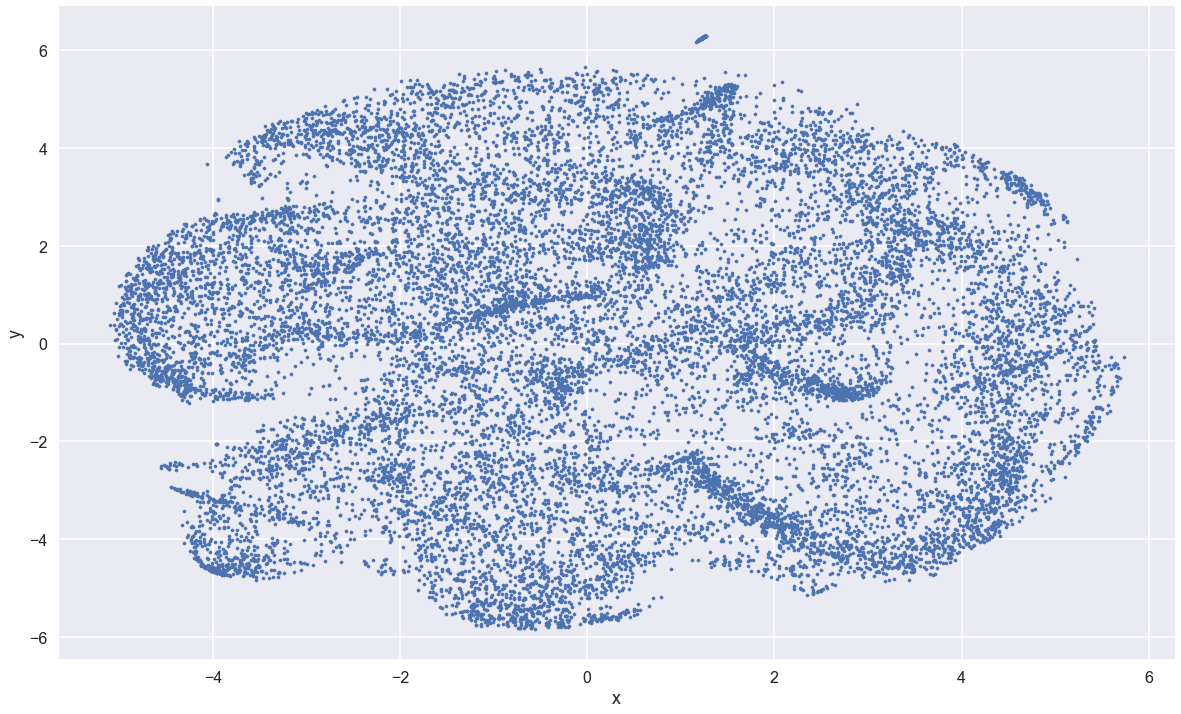

In [47]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

# Plot a particular area

In [52]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

# People related to Kingsguard ended up together

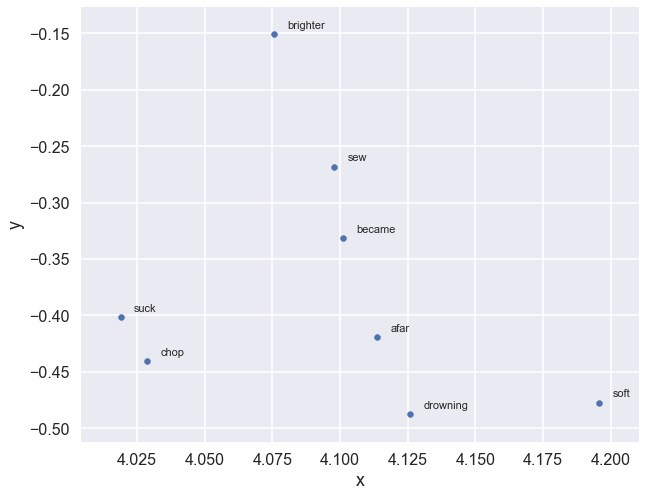

In [53]:
plot_region(x_bounds=(4.0, 4.2), y_bounds=(-0.5, -0.1))

# Food products are grouped

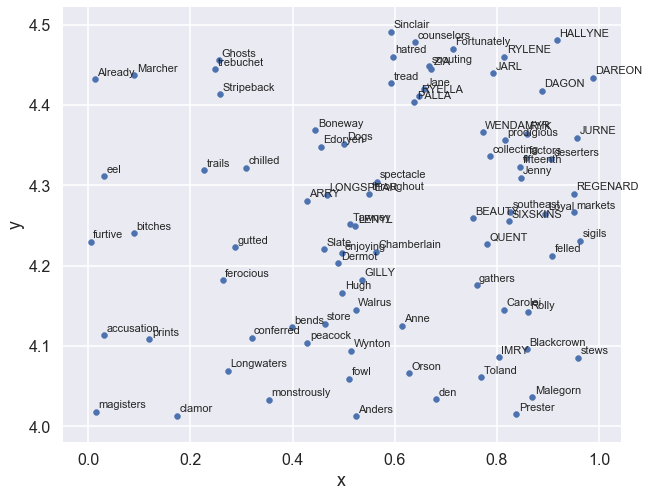

In [54]:
plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))

# Words closest to the given word

In [55]:
thrones2vec.most_similar("Stark")

[('Eddard', 0.9308791160583496),
 ('Arryn', 0.9207243919372559),
 ('Tully', 0.9046857357025146),
 ('Brandon', 0.9023438692092896),
 ('Hoster', 0.8895224332809448),
 ('Greyjoy', 0.8832991123199463),
 ('Rhaegar', 0.8820511102676392),
 ('Winterfell', 0.8819960355758667),
 ('Lysa', 0.8808213472366333),
 ('Benjen', 0.8804706335067749)]

In [56]:
thrones2vec.most_similar("Aerys")

[('Mad', 0.9570180177688599),
 ('Renly', 0.9547159075737),
 ('Brandon', 0.9538820385932922),
 ('Robert', 0.9492546916007996),
 ('Dragonstone', 0.9483400583267212),
 ('Martell', 0.9462061524391174),
 ('Rhaegar', 0.9412883520126343),
 ('Wolf', 0.9394446015357971),
 ('Hoster', 0.9393306374549866),
 ('Young', 0.9382781982421875)]

In [57]:
thrones2vec.most_similar("direwolf")

[('giant', 0.9136165380477905),
 ('raven', 0.9033651351928711),
 ('corpse', 0.9007140398025513),
 ('greatsword', 0.8984324932098389),
 ('laughter', 0.8981289267539978),
 ('Mountain', 0.8978043794631958),
 ('Longclaw', 0.89558345079422),
 ('shade', 0.8904849290847778),
 ('missing', 0.8884102702140808),
 ('memory', 0.8857877254486084)]

# Linear relationships between word pairs

In [58]:
#distance, similarity, and ranking
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [59]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as Arianne is related to wine
Arya is related to Nymeria, as Dany is related to dragons


'Dany'

In [61]:
nearest_similarity_cosmul("Jon", "winter", "wall")

Jon is related to winter, as Ghost is related to wall


'Ghost'